In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from astropy.cosmology import WMAP9 as cosmology
from astropy.cosmology import z_at_value
import astropy.units as u
from KDEpy import FFTKDE  # Fastest 1D algorithm
import h5py as h5
import matplotlib.colors as mcolors

# Import COMPAS specific scripts
sys.path.append('/n/home04/aboesky/pgk/COMPAS/utils/CosmicIntegration')
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_1310036/2581250938.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
plt.rcParams['text.usetex'] = False

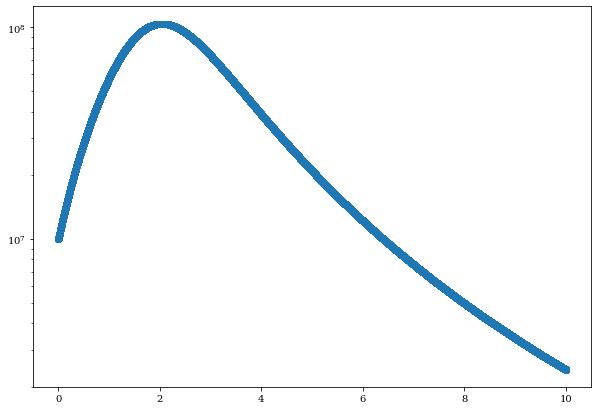

In [3]:
def SFR_Madau2(z):
    """
    https://arxiv.org/pdf/1606.07887.pdf
    """
    SFR = 0.01 * ((1+z)**2.6) / (1 + ((1+z)/3.2)**6.2) * 1e9 #[1e9 for GPc-3]
    return SFR # [Msun yr-1 Gpc-3] in comoving volume


fig = plt.figure(figsize=(10,7))

Ndraw=int(1E6)

z= np.linspace(0,10,Ndraw)

SFR = SFR_Madau2(z)




plt.scatter(z, SFR)

# plt.ylim(6, 8)
plt.yscale('log')
plt.show()



from scipy.stats import uniform

y_rej = uniform.rvs(10**6,10**9,size=Ndraw)

In [4]:
mask_rej =  (SFR < y_rej)

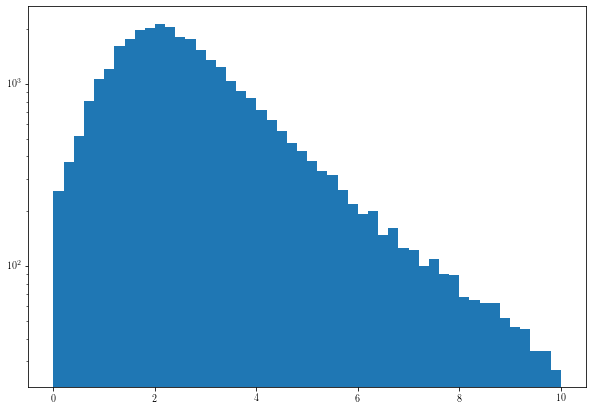

In [4]:
fig = plt.figure(figsize=(10,7))

plt.hist(z[~mask_rej],50)
plt.yscale('log')
plt.show()

In [3]:
ages_yrs = cosmology.age(z[~mask_rej]).to(u.Myr).value

ages_yrs_10 = ages_yrs * u.Myr + 10 * u.Myr
z_shifted_10 = z_at_value(cosmology.age, ages_yrs_10, zmin=-1)

ages_yrs_100 = ages_yrs * u.Myr + 100 * u.Myr
z_shifted_100 = z_at_value(cosmology.age, ages_yrs_100, zmin=-1)

ages_yrs_500 = ages_yrs * u.Myr + 0.5 * u.Gyr
z_shifted_500 = z_at_value(cosmology.age, ages_yrs_500, zmin=-1)

ages_yrs_1000 = ages_yrs * u.Myr + 1 * u.Gyr
z_shifted_1000 = z_at_value(cosmology.age, ages_yrs_1000, zmin=-1)

NameError: name 'z' is not defined

In [ ]:
axis = np.arange(-1, 10.1, 0.1)
scale_factor = len(z_shifted_10)

kde = FFTKDE(bw=0.2).fit(z[~mask_rej]).evaluate(axis)

kde_10 = FFTKDE(bw=0.2).fit(z_shifted_10).evaluate(axis)
kde_100 = FFTKDE(bw=0.2).fit(z_shifted_100).evaluate(axis)
kde_500 = FFTKDE(bw=0.2).fit(z_shifted_500).evaluate(axis)
kde_1000 = FFTKDE(bw=0.2).fit(z_shifted_1000).evaluate(axis)

In [7]:
def t_at_z(z):
    return cosmology.age(z).to(u.Myr).value

def z_at_t(t):
    return z_at_value(cosmology.age, t * u.Myr, zmin=-1)

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(17,7))
lw=2

# Top plot
ax[0].plot(axis, kde * scale_factor, color='k', lw=lw, label='Sample Stars')
ax[0].plot(axis, kde_10 * scale_factor, lw=lw, label='Sample Shifted by 10 Myr')
ax[0].plot(axis, kde_100 * scale_factor, lw=lw, label='Sample Shifted by 100 Myr')
ax[0].plot(axis, kde_500 * scale_factor, lw=lw, label='Sample Shifted by 500 Myr')
ax[0].plot(axis, kde_1000 * scale_factor, lw=lw, label='Sample Stars Shifted by 1 Gyr')
ax[0].set_yscale('log')
ax[0].set_ylim([1, 10E4])
ax[0].set_xlim([0,10])
ax[0].legend(fontsize=15, loc='lower left')
ax[0].set_xlabel(r'\textbf{Redshift}', fontsize=20)
ax[0].set_ylabel(r'\textbf{Star Density}', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)

ax2  = ax[0].twiny()
# second x-axis for age
# axes2.xaxis.labelpad = 20
ax2.tick_params(labelsize=15)
redshifts = np.linspace(0,6,100)
#strolger works in age not redshift
ages      = cosmology.age(redshifts).value
#find nearest redshift to age
agelabels = np.array([1,2,3,4,5,7, 9]) #Gyr
ageUniverse = cosmology.age(0)
redshiftTicks = np.zeros(len(agelabels))
for nr, age in enumerate(agelabels):
    distance = np.abs(ages-age)
    ind      = np.where(distance==np.min(distance))[0][0]
    redshiftTicks[nr] =  redshifts[ind]

ax2.set_xticks(redshiftTicks)
ax2.set_xticklabels(agelabels)
nameX2 = r'\textbf{age universe [Gyr]}'
ax2.set_xlabel(nameX2, fontsize=20, labelpad=8)

# Bottom plot
SFR = SFR_Madau2(axis)
sfr_area = np.trapz(SFR, x=axis)               # Get the area under the curve
SFR_norm = SFR/sfr_area
ax[1].plot(axis, kde/SFR_norm, lw=lw, color='k', label='Sample Stars')
ax[1].plot(axis, kde_10/SFR_norm, lw=lw, label='Sample Shifted by 10 Myr')
ax[1].plot(axis, kde_100/SFR_norm, lw=lw, label='Sample Shifted by 100 Myr')
ax[1].plot(axis, kde_500/SFR_norm, lw=lw, label='Sample Shifted by 500 Myr')
ax[1].plot(axis, kde_1000/SFR_norm, lw=lw, label='Sample Shifted by 1 Gyr')
ax[1].set_yscale('log')
ax[1].set_ylim([10**-1, 2])
ax[1].set_xlim([0,10])
ax[1].set_xlabel(r'\textbf{Redshift}', fontsize=20)
ax[1].set_ylabel(r'\textbf{$|\textrm{Star Density}|  \ \  /  \ \  |\textrm{SFR}(z)|$}', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
# Plot horizontal line for SFR on the normalized plots
ax[1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

ax2  = ax[1].twiny()
# second x-axis for age
# axes2.xaxis.labelpad = 20
ax2.tick_params(labelsize=15)
redshifts = np.linspace(0,6,100)
#strolger works in age not redshift
ages      = cosmology.age(redshifts).value
#find nearest redshift to age
agelabels = np.array([1,2,3,4,5,7, 9]) #Gyr
ageUniverse = cosmology.age(0)
redshiftTicks = np.zeros(len(agelabels))
for nr, age in enumerate(agelabels):
    distance = np.abs(ages-age)
    ind      = np.where(distance==np.min(distance))[0][0]
    redshiftTicks[nr] =  redshifts[ind]

ax2.set_xticks(redshiftTicks)
ax2.set_xticklabels(agelabels)
nameX2 = r'\textbf{age universe [Gyr]}'
ax2.set_xlabel(nameX2, fontsize=20, labelpad=8)
fig.tight_layout()

/tmp/ipykernel_576985/3846558512.py:43: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(axis, kde/SFR_norm, lw=lw, color='k', label='Sample Stars')
/tmp/ipykernel_576985/3846558512.py:44: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(axis, kde_10/SFR_norm, lw=lw, label='Sample Shifted by 10 Myr')
/tmp/ipykernel_576985/3846558512.py:45: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(axis, kde_100/SFR_norm, lw=lw, label='Sample Shifted by 100 Myr')
/tmp/ipykernel_576985/3846558512.py:46: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(axis, kde_500/SFR_norm, lw=lw, label='Sample Shifted by 500 Myr')
/tmp/ipykernel_576985/3846558512.py:47: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(axis, kde_1000/SFR_norm, lw=lw, label='Sample Shifted by 1 Gyr')


ValueError: 
|\textrm{Star Density}|  \ \  /  \ \  |\textrm{SFR}(z)|
 ^
Unknown symbol: \textrm, found '\'  (at char 1), (line:1, col:2)

ValueError: 
|\textrm{Star Density}|  \ \  /  \ \  |\textrm{SFR}(z)|
 ^
Unknown symbol: \textrm, found '\'  (at char 1), (line:1, col:2)

<Figure size 1224x504 with 4 Axes>

In [ ]:
print(length(ages_yrs))

In [10]:
test = np.arange(0,10.1, 0.1)

In [3]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha + '_beta_' + beta + '/COMPAS_Output_Weighted.h5'

In [3]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
weight_column   = 'mixture_weight'
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 * (1 + max_redshift_detection)
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

rainbow_cmap = matplotlib.cm.get_cmap('rainbow')
num_colors = len(alpha_vals)*len(beta_vals)
counter = 0
color_grid = {}
for alphva_index, alpha_val in enumerate(alpha_vals):
    color_grid[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        color_grid[alpha_val][beta_val] = rainbow_cmap(counter/num_colors)
        counter+=1

# Van Son 2022 prescriptions:
mu0             = 0.025
muz             = -0.048
sigma0          = 1.125
sigmaz          = 0.048
alpha           = -1.77

aSF             = 0.02
bSF             = 1.48 
cSF             = 4.45 
dSF             = 5.9

# MY FIDUCIAL MSSFR PRESCRIPTIONS
lognormal=False                                     # !!! IF THIS PARAMETER IS FALSE, IT WILL USE THE NON-LOGNORMAL MSSFR PRESCRIPTIONS !!!
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2016)'
logNormalPrescription=None

NameError: name 'alpha_vals' is not defined

In [4]:
def plot_delay_time_distribution(condensed_paths, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # The desired redshifts
    redshifts = ['0.2', '2.0', '6.0']
    
    folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val
    
    # Dictionary to put all the weights in
    merger_weights = {}

    with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_weights_at_redshifts.h5', 'rb') as f:

        for desired_z in redshifts:
            # Get data
            h5_data = h5.File(f)
            merger_weights[desired_z] = h5_data['redshift_' + desired_z]['total_formation_rates'][...]
    
    # start by getting the necessary data from the COMPAS file
    COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
    COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
    COMPAS.setCOMPASData()
    COMPAS.set_sw_weights(weight_column)
    
    # Mak masks to filer for the channel only
    time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
    t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
        

    ####### Plot
    fig = plt.figure(figsize=(10,7))
    
    # Iterate through redshift values and plot delay time distributions
    for desired_z in redshifts:
        # axis = np.linspace(0, max(t_delay)+10, num=1000)
        # kde = FFTKDE(bw=100).fit(t_delay, weights=merger_weights[desired_z]).evaluate(axis)
        # plt.plot(axis, kde, label='z = ' + desired_z)

        # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0.5, 3.2, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        
        plt.hist(t_delay, weights=merger_weights[desired_z], bins=np.linspace(0, 15000, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            alpha=1, lw=1.5)




        # if desired_z == '2.0':
        #     plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, zorder=-1, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        # else:
            # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            #    alpha=1, lw=1.5)
            
    
    # Format
    plt.legend(fontsize=15)
    plt.xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
    plt.ylabel(r'\textbf{Density}', fontsize=20)
    plt.yscale('log')
    # plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

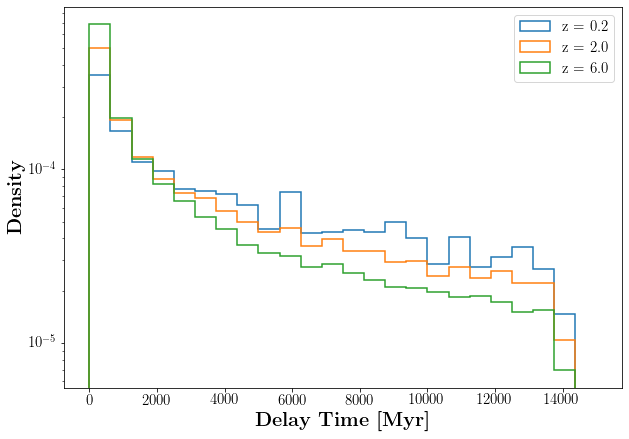

In [17]:
plot_delay_time_distribution(condensed_paths, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                               

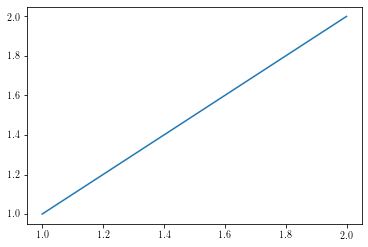

In [26]:
import matplotlib.colors as mcolors
plt.plot([1,2], [1,2], mcolors.TABLEAU_COLORS['tab:blue'])

In [21]:
def plot_observable_delay_time_distribution(condensed_paths, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # The desired redshifts
    redshifts = ['0.2', '2.0', '6.0']
    
    folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val
    
    # Dictionary to put all the weights in
    merger_weights = {}

    with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_weights_at_redshifts.h5', 'rb') as f:

        for desired_z in redshifts:
            # Get data
            h5_data = h5.File(f)
            merger_weights[desired_z] = h5_data['redshift_' + desired_z]['total_formation_rates'][...]
    
    # start by getting the necessary data from the COMPAS file
    COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
    COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
    COMPAS.setCOMPASData()
    COMPAS.set_sw_weights(weight_column)
    
    # Mak masks to filer for the channel only
    time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
    t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
        

    ####### Plot
    fig = plt.figure(figsize=(10,7))
    color_labels = ['tab:blue', 'tab:orange', 'tab:green']
    heights = [10**0.32, 10**1.33, 10**0.58]
    
    # Iterate through redshift values and plot delay time distributions
    for index, desired_z in enumerate(redshifts):
        # axis = np.linspace(0, max(t_delay)+10, num=1000)
        # kde = FFTKDE(bw=100).fit(t_delay, weights=merger_weights[desired_z]).evaluate(axis)
        # plt.plot(axis, kde, label='z = ' + desired_z)

        # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0.5, 3.2, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        
        plt.hist(t_delay, weights=merger_weights[desired_z], bins=np.linspace(0, 15000, 25), label='z = ' + desired_z, density=False, histtype='step', facecolor='g',
            edgecolor = mcolors.TABLEAU_COLORS[color_labels[index]], alpha=1, lw=1.5)

        # Get the minimum delay time for mergers at the given redshift to be observable
        lookback_at_z_gyr = cosmology.lookback_time(float(desired_z))
        print('Minimum delay time for z =', desired_z, ':  ', lookback_at_z_gyr)
        # plt.plot(lookback_at_z_gyr*1000, heights[index], marker='*', markersize=18, color=mcolors.TABLEAU_COLORS[color_labels[index]])  # Plot a star at this value

        # Plot a grey box for the unobservable mergers
        unobservable_mask = [t_delay >= lookback_at_z_gyr/u.Myr]
        plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
            edgecolor = 'lightgray', alpha=1, lw=1.5, zorder=-2, fill=True)
        plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
            edgecolor = mcolors.TABLEAU_COLORS[color_labels[index]], alpha=1, lw=1.5, zorder=-1, hatch='/', fill=True)

        # if desired_z == '2.0':
        #     plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, zorder=-1, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        # else:
            # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            #    alpha=1, lw=1.5)
            
    
    # Format
    plt.legend(fontsize=15)
    plt.xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
    plt.ylabel(r'\textbf{Density}', fontsize=20)
    plt.yscale('log')
    # plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

Minimum delay time for z = 0.2 :   2.4605559743096297 Gyr


/tmp/ipykernel_188235/3647705568.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
/tmp/ipykernel_188235/3647705568.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',


Minimum delay time for z = 2.0 :   10.442114407635646 Gyr


/tmp/ipykernel_188235/3647705568.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
/tmp/ipykernel_188235/3647705568.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',


Minimum delay time for z = 6.0 :   12.824270497992012 Gyr


/tmp/ipykernel_188235/3647705568.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
/tmp/ipykernel_188235/3647705568.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',


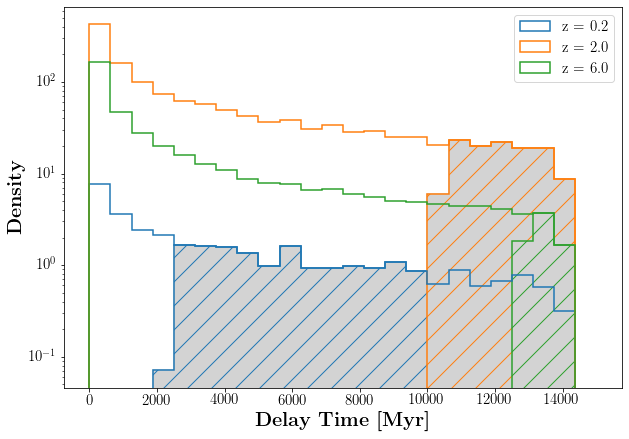

In [22]:
plot_observable_delay_time_distribution(condensed_paths, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                               

In [35]:
def plot_observable_delay_time_distribution_with_shape(condensed_paths, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # The desired redshifts
    redshifts = ['0.2', '2.0', '6.0']
    
    folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val
    
    # Dictionary to put all the weights in
    merger_weights = {}

    with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_weights_at_redshifts.h5', 'rb') as f:

        for desired_z in redshifts:
            # Get data
            h5_data = h5.File(f)
            merger_weights[desired_z] = h5_data['redshift_' + desired_z]['total_formation_rates'][...]
    
    # start by getting the necessary data from the COMPAS file
    COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
    COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
    COMPAS.setCOMPASData()
    COMPAS.set_sw_weights(weight_column)
    
    # Mak masks to filer for the channel only
    time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
    t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
        

    ####### Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
    color_labels = ['tab:blue', 'tab:orange', 'tab:green']
    heights = [10**0.32, 10**1.33, 10**0.58]
    
    # Iterate through redshift values and plot delay time distributions
    for index, desired_z in enumerate(redshifts):
        # axis = np.linspace(0, max(t_delay)+10, num=1000)
        # kde = FFTKDE(bw=100).fit(t_delay, weights=merger_weights[desired_z]).evaluate(axis)
        # plt.plot(axis, kde, label='z = ' + desired_z)

        # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0.5, 3.2, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        
        ax1.hist(t_delay, weights=merger_weights[desired_z], bins=np.linspace(0, 15000, 25), label='z = ' + desired_z, density=False, histtype='step', facecolor='g',
            edgecolor = mcolors.TABLEAU_COLORS[color_labels[index]], alpha=1, lw=1.5)

        # Get the minimum delay time for mergers at the given redshift to be observable
        lookback_at_z_gyr = cosmology.lookback_time(float(desired_z))
        print('Minimum delay time for z =', desired_z, ':  ', lookback_at_z_gyr)
        # plt.plot(lookback_at_z_gyr*1000, heights[index], marker='*', markersize=18, color=mcolors.TABLEAU_COLORS[color_labels[index]])  # Plot a star at this value

        # Plot a grey box for the unobservable mergers
        unobservable_mask = [t_delay >= lookback_at_z_gyr/u.Myr]
        ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
            edgecolor = 'lightgray', alpha=1, lw=1.5, zorder=-2, fill=True)
        ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
            edgecolor = mcolors.TABLEAU_COLORS[color_labels[index]], alpha=1, lw=1.5, zorder=-1, hatch='/', fill=True)

        ax2.hist(t_delay, weights=merger_weights[desired_z], bins=np.linspace(0, 15000, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            alpha=1, lw=1.5)

        # if desired_z == '2.0':
        #     plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, zorder=-1, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        # else:
            # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            #    alpha=1, lw=1.5)
            
    
    # Format
    plt.legend(fontsize=15)
    ax1.set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
    ax1.set_ylabel(r'\textbf{Density}', fontsize=20)
    ax1.set_yscale('log')
    ax2.set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
    ax2.set_ylabel(r'\textbf{Density}', fontsize=20)
    ax2.set_yscale('log')
    # plt.xscale('log')
    ax1.tick_params(labelsize=15)
    ax2.tick_params(labelsize=15)

Minimum delay time for z = 0.2 :   2.4605559743096297 Gyr


/tmp/ipykernel_188235/3650277921.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
/tmp/ipykernel_188235/3650277921.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',


Minimum delay time for z = 2.0 :   10.442114407635646 Gyr


/tmp/ipykernel_188235/3650277921.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
/tmp/ipykernel_188235/3650277921.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',


Minimum delay time for z = 6.0 :   12.824270497992012 Gyr


/tmp/ipykernel_188235/3650277921.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',
/tmp/ipykernel_188235/3650277921.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=np.linspace(0, 15000, 25), density=False, histtype='step', facecolor='lightgray',


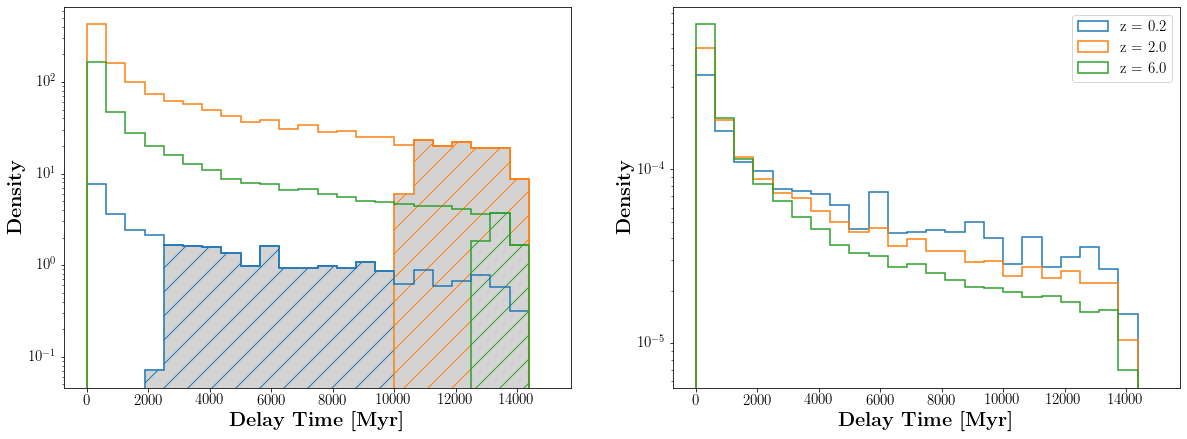

In [36]:
plot_observable_delay_time_distribution_with_shape(condensed_paths, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                               

In [9]:
def weighted_quantile(values, quantiles, sample_weight=None,
                      values_sorted=False, old_style=False):
    """ 
    FROM FLOOR

    Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'
    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]
    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
        
    return np.interp(quantiles, weighted_quantiles, values)

In [8]:
def plot_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.005,   0.05,   0.16,   0.25,   0.5,   0.75,   0.84,   0.95,  0.995]
    quantile_estimates = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    quantile_estimates[alpha_val][beta_val].append(weighted_quantile(t_delay, quants, sample_weight=weights[:,z_index]))

                quantile_estimates[alpha_val][beta_val] = np.array(quantile_estimates[alpha_val][beta_val])
    
    fig = plt.figure(figsize=(14,9))
    dz = redshifts[1] - redshifts[0]
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,4], color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,3], color=color_grid[alpha_val][beta_val], linestyle='dashed')
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,5], color=color_grid[alpha_val][beta_val], linestyle='dashed')
            # plt.plot(redshifts, np.sum(weights,axis=0), color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

            # scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val][:,4]) * dz
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,4]/scale_factor, color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            # plt.fill_between(x=redshifts, y1=quantile_estimates[alpha_val][beta_val][:,3], y2=quantile_estimates[alpha_val][beta_val][:,5], alpha=0.2, color=color_grid[alpha_val][beta_val])
            # plt.fill_between(x=redshifts, y1=quantile_estimates[alpha_val][beta_val][:,2], y2=quantile_estimates[alpha_val][beta_val][:,6], alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            plt.ylabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            plt.xlabel(r'\textbf{Redshift}', fontsize=20)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

        # Include legend
    leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=(0.88, 1.14),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)


    plt.xlim([0, redshifts[-1]])
    plt.ylim([0, plt.ylim()[1]])
    # plt.yscale('log')
                            


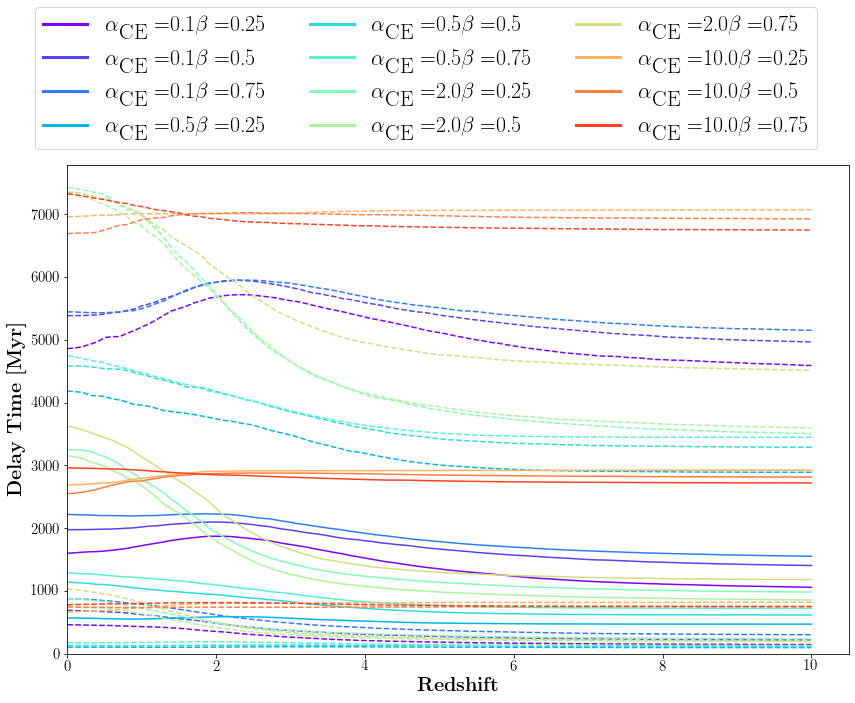

In [17]:
plot_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

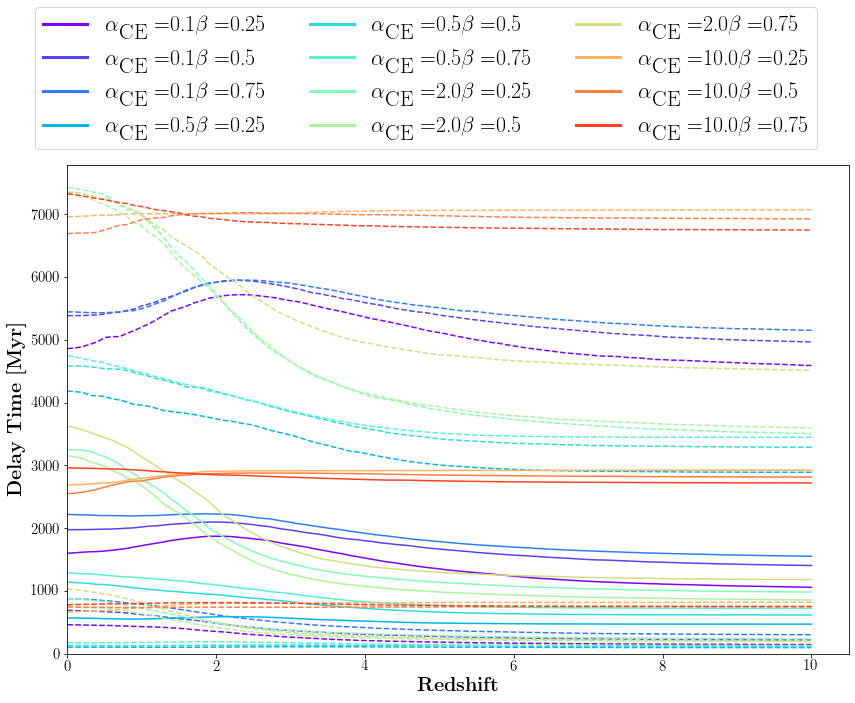

In [10]:
plot_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

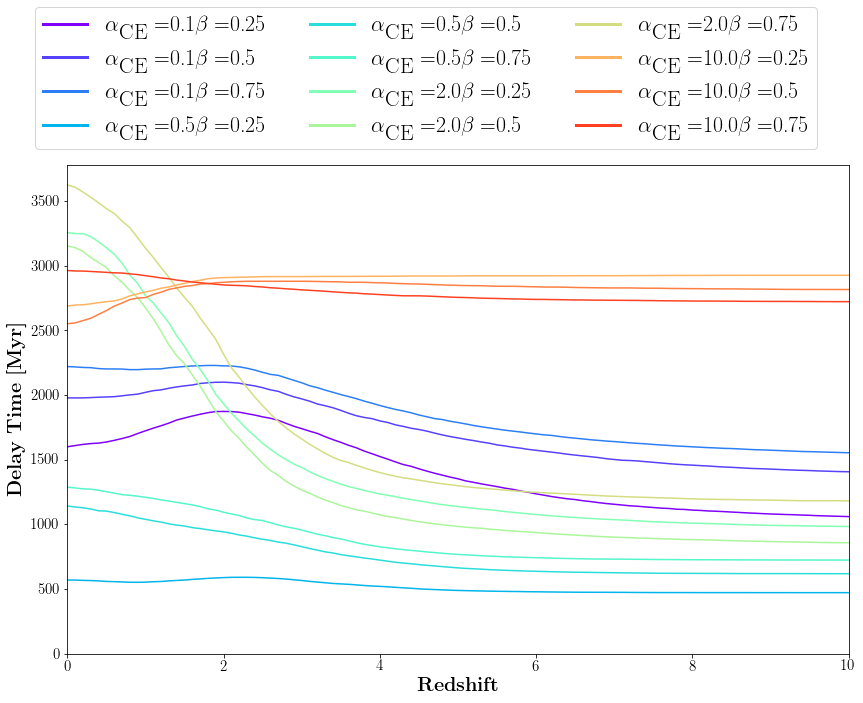

In [9]:
plot_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

In [5]:
def get_tallest_bins(data: np.ndarray, weights: np.ndarray, num_bins: int = 20, num_returned_bins: int = 5):
    max_delay_time = 14500  # Myr from above plots
    dx = max_delay_time / num_bins
    bins = np.linspace(dx/2, 14500, num=num_bins)
    heights, bin_edges = np.histogram(data, weights=weights, bins=bins)
    tallest_indxs = np.argpartition(heights, -4)[-num_returned_bins:]
    dx = bin_edges[1] - bin_edges[0]
    increasing = np.argsort(heights[tallest_indxs])
    return heights[tallest_indxs][increasing], bin_edges[tallest_indxs][increasing], dx

In [6]:
m1_min=5 * u.Msun
m1_max=150 * u.Msun
m2_min=0.1 * u.Msun 
fbin=1.0

folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_0.1_beta_0.5'

with open(folder_path + '/Pickled_Rates/MSSFR_111/BBH/all_rates_weights_at_redshifts.h5', 'rb') as f:
    h5_data = h5.File(f)
    weights = h5_data['actual']['total_formation_rates'][...]
    
    redshifts = h5_data['actual']['redshifts'][...]

    # start by getting the necessary data from the COMPAS file
    COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
    COMPAS.setCOMPASDCOmask(types='BBH', withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
    COMPAS.setCOMPASData()
    COMPAS.set_sw_weights(weight_column)
    
    # Mak masks to filer for the channel only
    time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
    t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
    # for z_index, z in enumerate(redshifts):
    #     max_bins[alpha_val][beta_val].append(get_tallest_bins(t_delay))

    z = 0
    z_index = 0
    dz = 10


    heights, edges, dh = get_tallest_bins(t_delay, weights[:,z_index])
    half_width = dh / 2
    indx = 0
    max_indx = len(heights)
    fig, ax = plt.subplots(1,1,figsize = (12,10))
    for height, edge in zip(heights, edges):
        indx += 1
        alpha = indx / max_indx
        rect = patches.Rectangle((z, edge - half_width), dz, dh, linewidth=0, facecolor='blue', alpha=alpha)
        ax.add_patch(rect)

    ax.set_ylim((0, 6000))
    ax.set_xlim(0, 20)
    plt.show()

<BarContainer object of 5 artists>

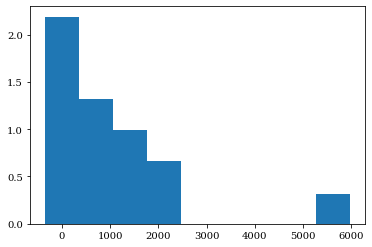

In [44]:
plt.bar(x=edges, height=heights, width=dx)

In [ ]:
def plot_t_delay_modes_per_z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.005,   0.05,   0.16,   0.25,   0.5,   0.75,   0.84,   0.95,  0.995]
    max_bins = {}
    index = 0

    for alpha_val in alpha_vals:
        max_bins[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                max_bins[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    max_bins[alpha_val][beta_val].append(get_tallest_bins(t_delay, quants, sample_weight=weights[:,z_index]))

                max_bins[alpha_val][beta_val] = np.array(max_bins[alpha_val][beta_val])
    
    fig = plt.figure(figsize=(14,9))
    dz = redshifts[1] - redshifts[0]
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            plt.plot(redshifts, max_bins[alpha_val][beta_val][:,4], color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,3], color=color_grid[alpha_val][beta_val], linestyle='dashed')
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,5], color=color_grid[alpha_val][beta_val], linestyle='dashed')
            # plt.plot(redshifts, np.sum(weights,axis=0), color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

            # scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val][:,4]) * dz
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,4]/scale_factor, color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            # plt.fill_between(x=redshifts, y1=quantile_estimates[alpha_val][beta_val][:,3], y2=quantile_estimates[alpha_val][beta_val][:,5], alpha=0.2, color=color_grid[alpha_val][beta_val])
            # plt.fill_between(x=redshifts, y1=quantile_estimates[alpha_val][beta_val][:,2], y2=quantile_estimates[alpha_val][beta_val][:,6], alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            plt.ylabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            plt.xlabel(r'\textbf{Redshift}', fontsize=20)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

        # Include legend
    leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=(0.88, 1.14),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)


    plt.xlim([0, redshifts[-1]])
    plt.ylim([0, plt.ylim()[1]])
    # plt.yscale('log')
                            

In [14]:
# # from sklearn.utils.extmath import weighted_mode
# def weighted_mode(a, w, *, axis=0):
#     """Return an array of the weighted modal (most common) value in the passed array.
#     If there is more than one such value, only the first is returned.
#     The bin-count for the modal bins is also returned.
#     This is an extension of the algorithm in scipy.stats.mode.
#     Parameters
#     ----------
#     a : array-like of shape (n_samples,)
#         Array of which values to find mode(s).
#     w : array-like of shape (n_samples,)
#         Array of weights for each value.
#     axis : int, default=0
#         Axis along which to operate. Default is 0, i.e. the first axis.
#     Returns
#     -------
#     vals : ndarray
#         Array of modal values.
#     score : ndarray
#         Array of weighted counts for each mode.
#     See Also
#     --------
#     scipy.stats.mode: Calculates the Modal (most common) value of array elements
#         along specified axis.
#     Examples
#     --------
#     >>> from sklearn.utils.extmath import weighted_mode
#     >>> x = [4, 1, 4, 2, 4, 2]
#     >>> weights = [1, 1, 1, 1, 1, 1]
#     >>> weighted_mode(x, weights)
#     (array([4.]), array([3.]))
#     The value 4 appears three times: with uniform weights, the result is
#     simply the mode of the distribution.
#     >>> weights = [1, 3, 0.5, 1.5, 1, 2]  # deweight the 4's
#     >>> weighted_mode(x, weights)
#     (array([2.]), array([3.5]))
#     The value 2 has the highest score: it appears twice with weights of
#     1.5 and 2: the sum of these is 3.5.
#     """
#     if axis is None:
#         a = np.ravel(a)
#         w = np.ravel(w)
#         axis = 0
#     else:
#         a = np.asarray(a)
#         w = np.asarray(w)

#     if a.shape != w.shape:
#         w = np.full(a.shape, w, dtype=w.dtype)

#     scores = np.unique(np.ravel(a))  # get ALL unique values
#     testshape = list(a.shape)
#     testshape[axis] = 1
#     oldmostfreq = np.zeros(testshape)
#     oldcounts = np.zeros(testshape)
#     for score in scores:
#         template = np.zeros(a.shape)
#         ind = a == score
#         template[ind] = w[ind]
#         counts = np.expand_dims(np.sum(template, axis), axis)
#         mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
#         oldcounts = np.maximum(counts, oldcounts)
#         oldmostfreq = mostfrequent
#     return mostfrequent, oldcounts

def weighted_mode(times, weights):
    arg_mode = np.argmax(weights)
    return times[arg_mode]

In [9]:
def plot_t_delay_median_and_mode_per_z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.5]
    quantile_estimates = {}
    modes = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}
        modes[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = []
                modes[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    modes[alpha_val][beta_val].append(weighted_mode(t_delay, weights[:, z_index]))
                    quantile_estimates[alpha_val][beta_val].append(weighted_quantile(t_delay, quants, sample_weight=weights[:,z_index]))

                modes[alpha_val][beta_val] = np.array(modes[alpha_val][beta_val])
                quantile_estimates[alpha_val][beta_val] = np.array(quantile_estimates[alpha_val][beta_val])
    
    fig, axes = plt.subplots(1, 2, figsize=(28, 10))
    dz = redshifts[1] - redshifts[0]
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            axes[0].plot(redshifts, quantile_estimates[alpha_val][beta_val][0], color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            
            axes[0].set_ylabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=20)
            axes[0].tick_params(axis='both', labelsize=15)

        # Include legend
    leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=(0.88, 1.14),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)


    plt.xlim([0, redshifts[-1]])
    plt.ylim([0, plt.ylim()[1]])
    # plt.yscale('log')
                            


In [10]:
def get_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.5]
    quantile_estimates = {}
    modes = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}
        modes[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    quantile_estimates[alpha_val][beta_val].append(weighted_quantile(t_delay, quants, sample_weight=weights[:,z_index]))

                quantile_estimates[alpha_val][beta_val] = np.array(quantile_estimates[alpha_val][beta_val])

    return quantile_estimates

In [12]:
def get_mode_per_z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quantile_estimates = {}
    modes = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}
        modes[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = []
                modes[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    modes[alpha_val][beta_val].append(weighted_mode(t_delay, weights[:, z_index]))

                modes[alpha_val][beta_val] = np.array(modes[alpha_val][beta_val])
    
    return modes

In [ ]:
medians = get_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

In [15]:
modes = get_mode_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

In [ ]:
def plot_medians_and_modes(condensed_paths, alpha_vals, beta_vals, medians, modes, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.5]
    quantile_estimates = {}
    modes = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}
        modes[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = []
                modes[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    modes[alpha_val][beta_val].append(weighted_mode(t_delay, weights[:, z_index]))
                    quantile_estimates[alpha_val][beta_val].append(weighted_quantile(t_delay, quants, sample_weight=weights[:,z_index]))

                modes[alpha_val][beta_val] = np.array(modes[alpha_val][beta_val])
                quantile_estimates[alpha_val][beta_val] = np.array(quantile_estimates[alpha_val][beta_val])
    
    fig, axes = plt.subplots(1, 2, figsize=(28, 10))
    dz = redshifts[1] - redshifts[0]
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            axes[0].plot(redshifts, quantile_estimates[alpha_val][beta_val][0], color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            
            axes[0].set_ylabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=20)
            axes[0].tick_params(axis='both', labelsize=15)

        # Include legend
    leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=(0.88, 1.14),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)


    plt.xlim([0, redshifts[-1]])
    plt.ylim([0, plt.ylim()[1]])
    # plt.yscale('log')
                            


In [ ]:
modes = plot_medians_and_modes(condensed_paths, alpha_vals, beta_vals, medians, modes, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

In [2]:
def plot_t_delay_median_per_z_t_delay_specific(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.005,   0.05,   0.16,   0.25,   0.5,   0.75,   0.84,   0.95,  0.995]
    quantile_estimates = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_merger_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = {}
                quantile_estimates[alpha_val][beta_val]['10myr'] = []
                quantile_estimates[alpha_val][beta_val]['100myr'] = []
                quantile_estimates[alpha_val][beta_val]['1gyr'] = []

                t_mask_10myr = t_delay*u.Myr < 50*u.Myr
                t_mask_100myr = t_delay*u.Myr < 100*u.Myr
                t_mask_1gyr = t_delay*u.Myr < 1*u.Gyr

                for z_index, z in enumerate(redshifts):
                    if len(t_delay[t_mask_10myr]) == 0:
                        quantile_estimates[alpha_val][beta_val]['10myr'].append([0,0,0,0,0])
                    else:
                        quantile_estimates[alpha_val][beta_val]['10myr'].append(weighted_quantile(t_delay[t_mask_10myr], quants, sample_weight=weights[:,z_index][t_mask_10myr]))
                    quantile_estimates[alpha_val][beta_val]['100myr'].append(weighted_quantile(t_delay[t_mask_100myr], quants, sample_weight=weights[:,z_index][t_mask_100myr]))
                    quantile_estimates[alpha_val][beta_val]['1gyr'].append(weighted_quantile(t_delay[t_mask_1gyr], quants, sample_weight=weights[:,z_index][t_mask_1gyr]))

                quantile_estimates[alpha_val][beta_val]['10myr'] = np.array(quantile_estimates[alpha_val][beta_val]['10myr'])
                quantile_estimates[alpha_val][beta_val]['100myr'] = np.array(quantile_estimates[alpha_val][beta_val]['100myr'])
                quantile_estimates[alpha_val][beta_val]['1gyr'] = np.array(quantile_estimates[alpha_val][beta_val]['1gyr'])
    

    fig, ax = plt.subplots(1, 3, figsize=(25, 8))
    dz = redshifts[1] - redshifts[0]
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            # <10 Myr
            scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val]['10myr'][:,4]) * dz
            ax[0].plot(redshifts, quantile_estimates[alpha_val][beta_val]['10myr'][:,4]/scale_factor, color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            
            ax[0].set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            ax[0].set_ylabel(r'\textbf{Density}', fontsize=20)
            ax[0].tick_params(axis='both', labelsize=15)

            # <100 Myr
            scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val]['100myr'][:,4]) * dz
            ax[1].plot(redshifts, quantile_estimates[alpha_val][beta_val]['100myr'][:,4]/scale_factor, color=color_grid[alpha_val][beta_val])
            
            ax[1].set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            ax[1].set_ylabel(r'\textbf{Density}', fontsize=20)
            ax[1].tick_params(axis='both', labelsize=15)

            # <1 Gyr
            scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val]['1gyr'][:,4]) * dz
            ax[2].plot(redshifts, quantile_estimates[alpha_val][beta_val]['1gyr'][:,4]/scale_factor, color=color_grid[alpha_val][beta_val])
            
            ax[2].set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            ax[2].set_ylabel(r'\textbf{Density}', fontsize=20)
            ax[2].tick_params(axis='both', labelsize=15)


        # Include legend
    leg = fig.legend(fontsize=22, ncol=5, bbox_to_anchor=(0.87, 1.11),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
                            


/tmp/ipykernel_168390/494385708.py:34: RuntimeWarning: invalid value encountered in true_divide
  weighted_quantiles /= np.sum(sample_weight)


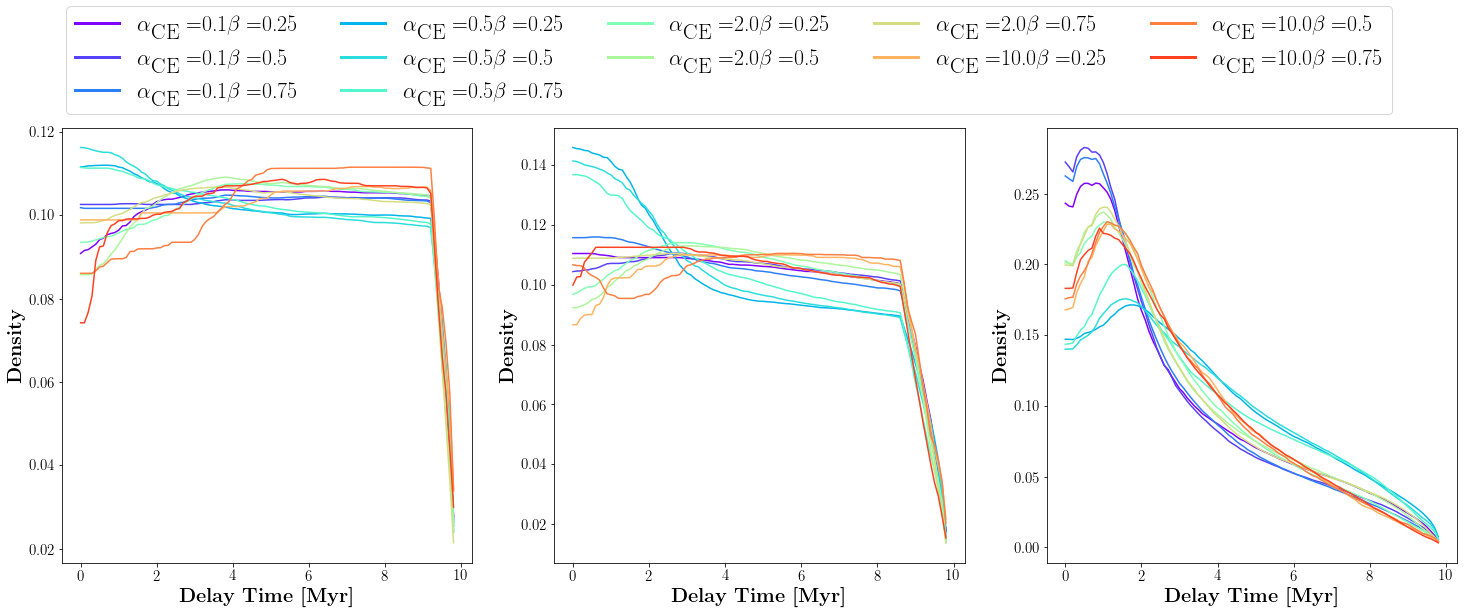

In [12]:
plot_t_delay_median_per_z_t_delay_specific(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))